# Waveform Selection

## Time Domain Signal
To begin with lets generate an example waveform to send. Initially we will use a chirp as a result of its good autocorrelation properties.

In [1]:
import numpy as np
from scipy import signal

# Parameters
fs = 30.72e6
T = 1/fs
L = 6144

# Generate Time Vector
t = np.linspace(0, L*T, L+1)

# Generate Signal - 10kHz to 1MHz Chirp
f0 = 10e3
f1 = 1e6
t1 = L*T
x = signal.chirp(t, f0, t1, f1, method='linear', phi=0)

Now lets plot the time domain signal:

<IPython.core.display.Javascript object>


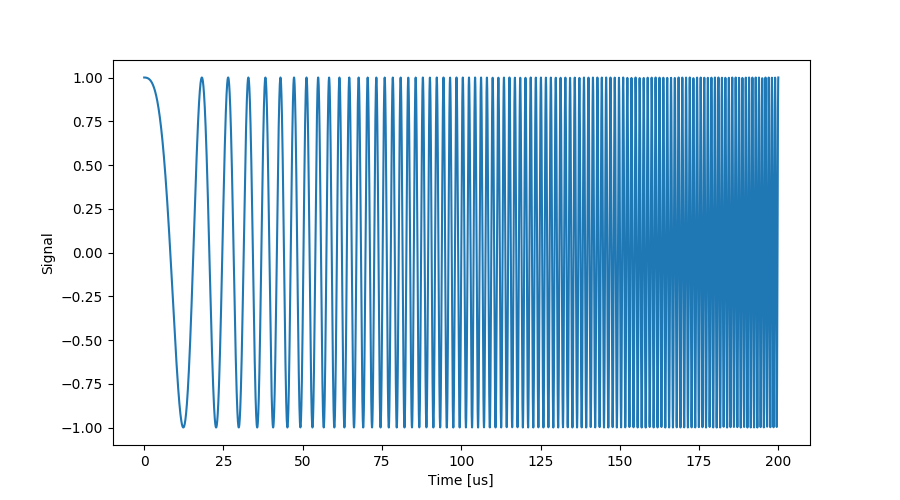

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Generate new figure
fig = plt.figure(figsize=(9, 5))

# Plot x(t) with t in microseconds
plt.plot(t*1e6,x)

# Label Axis
plt.xlabel('Time [us]')
plt.ylabel('Signal')
plt.show()

Lets confirm that L has been chosen correctly to ensure x(t) is continious in time:

In [3]:
x[0] == x[L]

True

## Signal Bandwidth
Next let us look at the frequency spectrum of the time domain signal x(t).

<IPython.core.display.Javascript object>


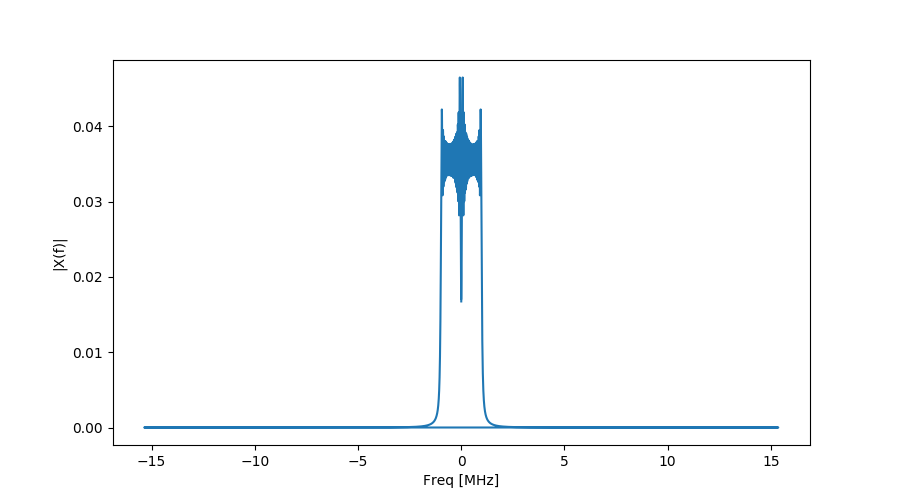

In [4]:
# Compute FFT & Frequency Bins
spectrum = np.fft.fft(x)
freq = np.fft.fftfreq(x.size, T)

# Plot Normalised |X(f)|
fig = plt.figure(figsize=(9, 5))
plt.plot(freq/1e6, np.abs(spectrum)/L)

# Label Axis
plt.xlabel('Freq [MHz]')
plt.ylabel('|X(f)|')
plt.show()

The spectrum is symmetric because the signal is real valued. The bandwidth of the signal is well below the Nyquist frequency set by our sampling rate of 30.72MS/s. Lets plot a segment of the positive frequency spectrum and determine the bandwidth of the signal.

<IPython.core.display.Javascript object>


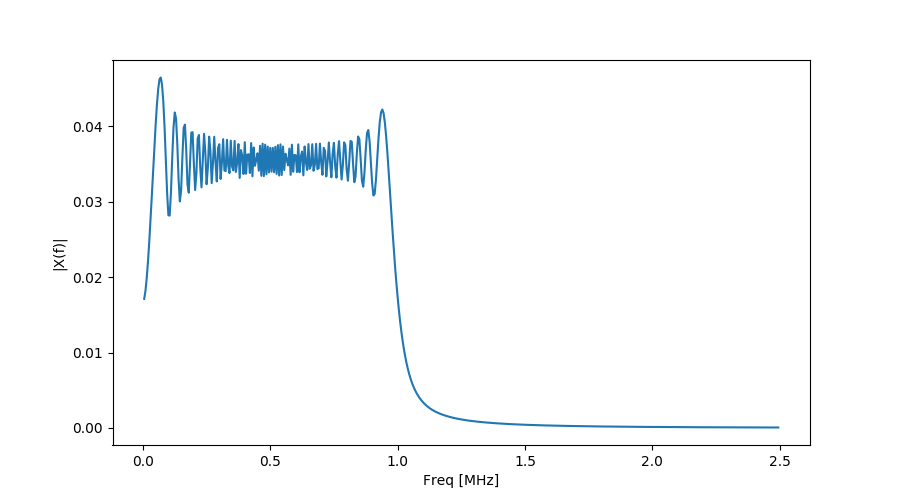

In [10]:
# Extract ~ 0 to 2.5MHz
zoom_spec = spectrum[1:500]
zoom_freq = freq[1:500]

# Plot Normalised |X(f)|
fig = plt.figure(figsize=(9, 5))
plt.plot(zoom_freq/1e6, np.abs(zoom_spec)/L)

# Label Axis
plt.xlabel('Freq [MHz]')
plt.ylabel('|X(f)|')
plt.show()

Unsurprisingly the bandwidth of the signal is set by the frequency f1 which is the upper instantaneous frequency of the chirp.



# Transmission

## Geometry
With the baseband signal selected lets model sending the data. In order to take account of the attenuation introduced by the FSPL we must first know the distance between recievers and transmitters. For simplicity we will initially consider a 2D problem.

<IPython.core.display.Javascript object>


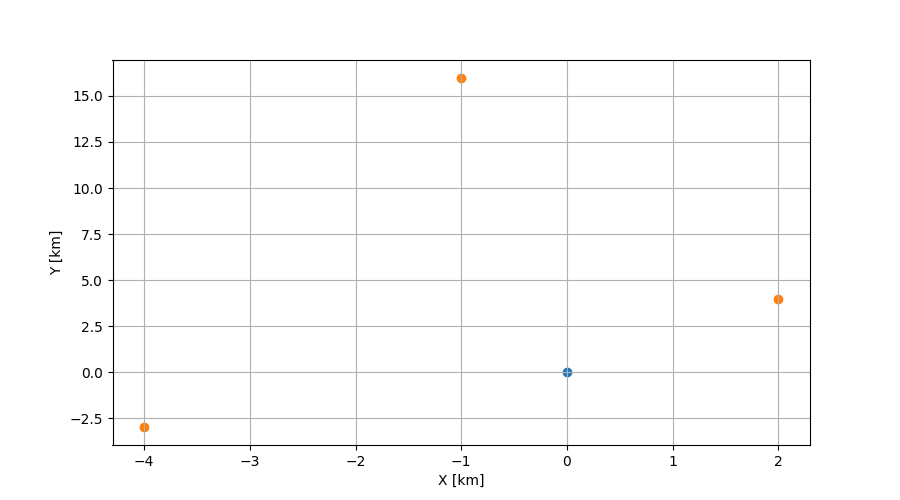

In [6]:
# TX Co-ordinates (km)
tx = np.array([0, 0])

# RX Co-ordinates (km)
rx1 = np.array([2, 4])
rx2 = np.array([-4, -3])
rx3 = np.array([-1, 16])

# Plot Geometry
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(tx))
ax1.scatter(*zip(*(rx1,rx2,rx3)))
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.grid(True)
plt.show()

Next lets compute the distance between the transmitter and each of the recievers allowing the time of flight to be determined.

In [7]:
import pandas as pd
from numpy import linalg as LA

# Distances (m)
d1 = LA.norm(tx-rx1)*1e3
d2 = LA.norm(tx-rx2)*1e3
d3 = LA.norm(tx-rx3)*1e3

# Times (s)
t1 = d1/(3e8)
t2 = d2/(3e8)
t3 = d3/(3e8)

# Num. Samples
n1 = t1/T
n2 = t2/T
n3 = t3/T

# Plot Table
data = [[d1,d2,d3], [t1*1e9,t2*1e9,t3*1e9], [n1,n2,n3]]
df = pd.DataFrame(np.transpose(data), ['RX1', 'RX2', 'RX3'], ['Distance (m)','TOF (ns)', 'Samples'])
df.round(2)

,Distance (m),TOF (ns),Samples
RX1,4472.14,14907.12,457.95
RX2,5000.00,16666.67,512.00
RX3,16031.22,53437.40,1641.60


# Time Delay

Lets generate the signals that should appear at the recievers. For now we will just round the TOF to be an integer multiple of the sampling period, which is equal to about 32.55 ns. This will give a conservative estimate of the system performance in return for increased simplicity of the model. Because x(t) is continious we can simply wrap the signal around.

<IPython.core.display.Javascript object>


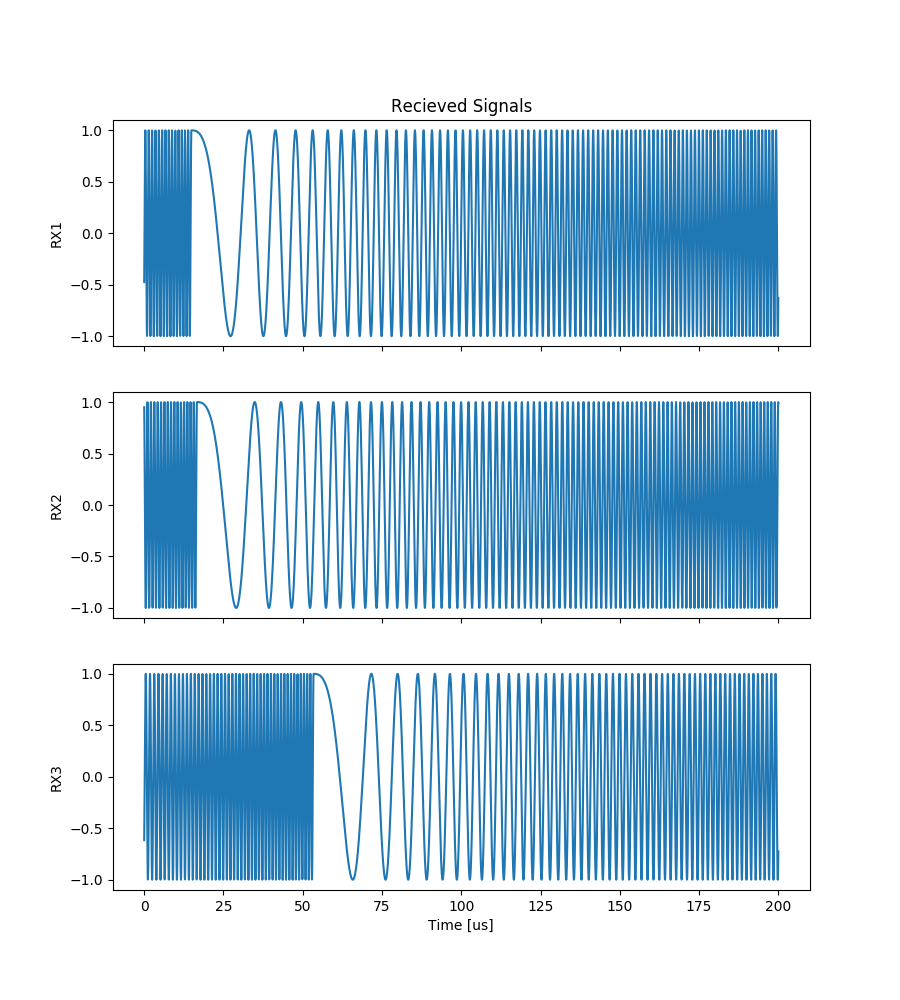

In [8]:
# Generate Recieved Signals
rx1_signal = np.roll(x, int(np.round(n1)))
rx2_signal = np.roll(x, int(np.round(n2)))
rx3_signal = np.roll(x, int(np.round(n3)))


# Plot Signals Sharing x-axis
f, axarr = plt.subplots(3, sharex=True, figsize=(9, 10))
axarr[0].plot(t*1e6, rx1_signal)
axarr[1].plot(t*1e6, rx2_signal)
axarr[2].plot(t*1e6, rx3_signal)

# Labels
axarr[0].set_title('Recieved Signals')
axarr[0].set_ylabel('RX1')
axarr[1].set_ylabel('RX2')
axarr[2].set_ylabel('RX3')
axarr[2].set_xlabel('Time [us]')

plt.show()

# Noise
The signal to noise ratio of the recieved signal is dependant on  both the free space path loss and the thermal noise at the recieve antenna. First let us calculate the power of the recieved signal.

## Link Budget

In [9]:
# TX Power
tx_power_mw = 500
tx_power_dbm = 10*np.log10(tx_power_mw)

# TX Gain/Loss
tx_gain = 0  # dB
tx_loss = 3  # dB

# RX Gain/Loss
rx_gain = 16 # dB
rx_loss = 3  # dB

# FSPL in dB at 2.4GHz
f = 2.4e9
fspl1 = 20*np.log10(f) + 20*np.log10(d1) - 147.55
fspl2 = 20*np.log10(f) + 20*np.log10(d2) - 147.55
fspl3 = 20*np.log10(f) + 20*np.log10(d3) - 147.55

# RX Power in dBm
rx_power_1_dBm = tx_power_dbm + tx_gain - tx_loss + rx_gain - rx_loss - fspl1
rx_power_2_dBm = tx_power_dbm + tx_gain - tx_loss + rx_gain - rx_loss - fspl2
rx_power_3_dBm = tx_power_dbm + tx_gain - tx_loss + rx_gain - rx_loss - fspl3

# Display Table
data = [[rx_power_1_dBm, rx_power_2_dBm, rx_power_3_dBm]]
df = pd.DataFrame(data, ['Power (dBm)'], ['RX1', 'RX2', 'RX3'])
df.round(0)

,RX1,RX2,RX3
Power (dBm),-76.0,-77.0,-87.0


Next we must determine the noise power in order to determine the SNR. - Microwave Engineering Ch. 14